# Preprocessing V2

In [1]:
import sys
!{sys.executable} -m pip install opencv-python
import cv2
!{sys.executable} -m pip install matplotlib
from matplotlib import pyplot as plt
!{sys.executable} -m pip install numpy
import numpy as np
!{sys.executable} -m pip install imutils
import imutils
!{sys.executable} -m pip install sklearn
from sklearn.decomposition import PCA
from math import atan2, cos, sin, sqrt, pi
from glob import glob
import os

In [2]:
filepaths = glob("images/*/*.png", recursive=True)
print(filepaths[:10])

['images/Trimed/trimed va ex1 at 4.05.14 AM.png', 'images/Trimed/trimed va ex1 at 4.05.20 AM.png', 'images/Trimed/trimed va ex1 at 4.07.05 AM.png', 'images/Trimed/trimed va ex1 at 4.05.59 AM.png', 'images/Trimed/trimed va ex1 at 4.06.49 AM (1).png', 'images/Trimed/trimed va ex1 at 4.05.14 AM (1).png', 'images/Trimed/trimed va ex1 at 4.06.59 AM.png', 'images/Trimed/trimed va ex1 at 4.05.20 AM (1).png', 'images/Trimed/trimed va ex1 at 4.05.25 AM (1).png', 'images/Trimed/trimed va ex1 at 4.06.49 AM.png']


In [3]:
images = {}

for filepath in filepaths:
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    # set crop bounds for background color detection
    x_min = 0
    x_max = image.shape[1]
    y_min = int(image.shape[0] * 0.2)
    y_max = int(image.shape[0] * 0.8)

    # recolored image (if black on white x-ray)
    cropped_image = image[y_min:y_max, x_min:x_max]
    
    recolored_image = image


    # print("MEAN", np.mean(cropped_image))
    if np.mean(cropped_image) > 110:
        recolored_image = cv2.bitwise_not(image)


    edited = recolored_image
    
    min = np.min(edited)
    max = np.max(edited)
    
    # scale pixels to 0 - 255 for max contrast
    scaled = ((edited - min) / (max - min) * 255).astype(np.uint8)
    
    images[filepath] = (image, scaled)


    # f, axarr = plt.subplots(1,2)
    # axarr[0].axis('off')
    # axarr[0].imshow(image, cmap='gray')
    # axarr[1].axis('off')
    # axarr[1].imshow(edited, cmap='gray')
    # plt.show(block=True)

## Now we actually try to preprocess the images

In [4]:
thresholded = {}

for filepath, (original, edited) in images.items():
    
    print(filepath)

    ret, thresh = cv2.threshold(edited, 200, 255, cv2.THRESH_TOZERO)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    thresholded[filepath] = morph
    
    # f, axarr = plt.subplots(1,2)
    # axarr[0].axis('off')
    # axarr[0].imshow(edited, cmap='gray')
    # axarr[1].axis('off')
    # axarr[1].imshow(morph, cmap='gray')
    # plt.show(block=True)

images/Trimed/trimed va ex1 at 4.05.14 AM.png
images/Trimed/trimed va ex1 at 4.05.20 AM.png
images/Trimed/trimed va ex1 at 4.07.05 AM.png
images/Trimed/trimed va ex1 at 4.05.59 AM.png
images/Trimed/trimed va ex1 at 4.06.49 AM (1).png
images/Trimed/trimed va ex1 at 4.05.14 AM (1).png
images/Trimed/trimed va ex1 at 4.06.59 AM.png
images/Trimed/trimed va ex1 at 4.05.20 AM (1).png
images/Trimed/trimed va ex1 at 4.05.25 AM (1).png
images/Trimed/trimed va ex1 at 4.06.49 AM.png
images/Trimed/trimed va ex1 at 4.07.05 AM (1).png
images/Trimed/trimed va ex1 at 4.05.25 AM.png
images/Trimed/trimed va ex1 at 4.06.59 AM (1).png
images/Trimed/trimed va ex1 at 4.05.54 AM.png
images/Trimed/trimed va ex1 at 4.05.59 AM (1).png
images/Trimed/trimed va ex1 at 4.05.54 AM (1).png
images/Acumed/acumed ex1 at 9.45.35 AM.png
images/Acumed/acumed ex1 at 2.22.39 PM (2).png
images/Acumed/acumed ex5 at 10.12.46 AM.png
images/Acumed/acumed ex5 at 10.25.37 AM (1).png
images/Acumed/acumed ex5 at 10.24.34 AM (1).png
im

In [5]:
rotated = {}

for filepath, thresh in thresholded.items():

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) if cv2.boundingRect(c)[2] < (thresh.shape[1]) * 0.8 else -1 for c in contours]
    max_index = np.argmax(areas)
    cnt = contours[max_index]
    
    pts = cnt
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
        
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    
    eigenvector = eigenvectors[0]

    angle = atan2(*eigenvector) # orientation in radians
    degrees = angle / np.pi * 180 # orientation in degrees

    # f, axarr = plt.subplots(1,2)
    # axarr[0].axis('off')
    # axarr[0].imshow(images[filepath][1], cmap='gray')
    # axarr[1].axis('off')
    # axarr[1].imshow(imutils.rotate_bound(thresh, degrees), cmap='gray')
    # plt.show(block=True)

    original = images[filepath][0]
    edited = images[filepath][1]
    rotated[filepath] = (imutils.rotate_bound(original, degrees), imutils.rotate_bound(edited, degrees), imutils.rotate_bound(thresh, degrees))


new filepath images_processed/Trimed/trimed va ex1 at 4.05.14 AM.png


new filepath images_processed/Trimed/trimed va ex1 at 4.05.20 AM.png


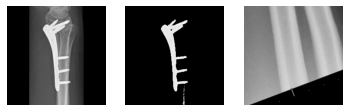

new filepath images_processed/Trimed/trimed va ex1 at 4.07.05 AM.png


new filepath images_processed/Trimed/trimed va ex1 at 4.05.59 AM.png


new filepath images_processed/Trimed/trimed va ex1 at 4.06.49 AM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



/var/folders/1f/0j682mk93d35p42prjrn5whr0000gn/T/ipykernel_14189/746935036.py:44: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axarr[2].imshow(crop_img, cmap='gray')


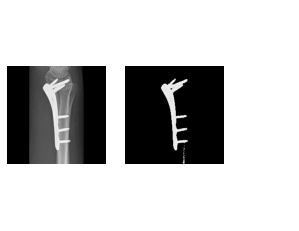

new filepath images_processed/Trimed/trimed va ex1 at 4.05.14 AM (1).png


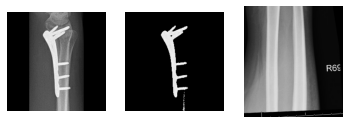

new filepath images_processed/Trimed/trimed va ex1 at 4.06.59 AM.png


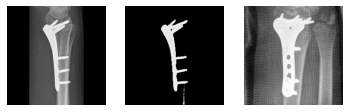

new filepath images_processed/Trimed/trimed va ex1 at 4.05.20 AM (1).png


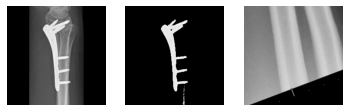

new filepath images_processed/Trimed/trimed va ex1 at 4.05.25 AM (1).png


new filepath images_processed/Trimed/trimed va ex1 at 4.06.49 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



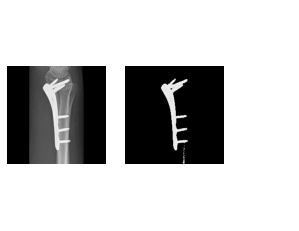

new filepath images_processed/Trimed/trimed va ex1 at 4.07.05 AM (1).png


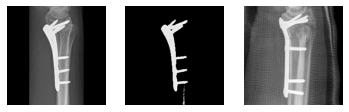

new filepath images_processed/Trimed/trimed va ex1 at 4.05.25 AM.png


new filepath images_processed/Trimed/trimed va ex1 at 4.06.59 AM (1).png


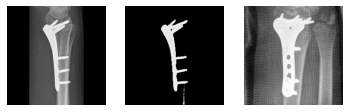

new filepath images_processed/Trimed/trimed va ex1 at 4.05.54 AM.png


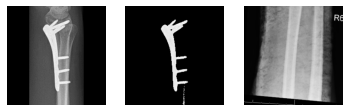

new filepath images_processed/Trimed/trimed va ex1 at 4.05.59 AM (1).png


new filepath images_processed/Trimed/trimed va ex1 at 4.05.54 AM (1).png


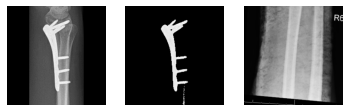

new filepath images_processed/Acumed/acumed ex1 at 9.45.35 AM.png


new filepath images_processed/Acumed/acumed ex1 at 2.22.39 PM (2).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



/var/folders/1f/0j682mk93d35p42prjrn5whr0000gn/T/ipykernel_14189/746935036.py:44: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  axarr[2].imshow(crop_img, cmap='gray')


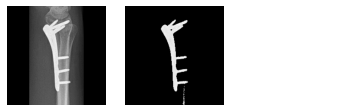

new filepath images_processed/Acumed/acumed ex5 at 10.12.46 AM.png


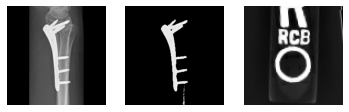

new filepath images_processed/Acumed/acumed ex5 at 10.25.37 AM (1).png


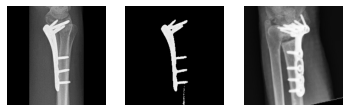

new filepath images_processed/Acumed/acumed ex5 at 10.24.34 AM (1).png


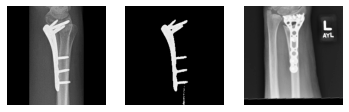

new filepath images_processed/Acumed/acumed ex3 at 9.58.41 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



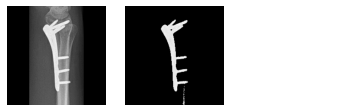

new filepath images_processed/Acumed/acumed ex5 at 10.25.26 AM (1).png


new filepath images_processed/Acumed/acumed ex1 at 9.47.19 AM (1).png


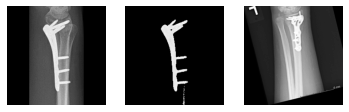

new filepath images_processed/Acumed/Acumed ex2 at 9.50.54 AM.png


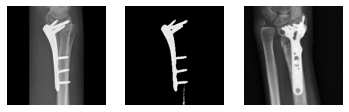

new filepath images_processed/Acumed/acumed ex1 at 2.21.10 PM.png


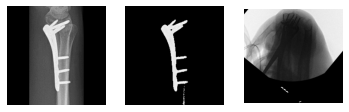

new filepath images_processed/Acumed/acumed ex5 at 10.25.26 AM.png


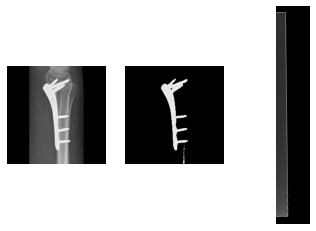

new filepath images_processed/Acumed/acumed ex3 at 2.20.02 PM.png


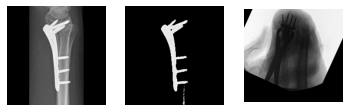

new filepath images_processed/Acumed/acumed ex1 at 2.22.42 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



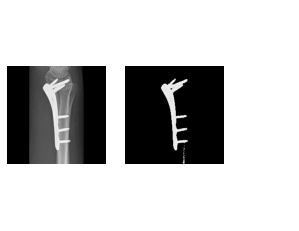

new filepath images_processed/Acumed/acumed ex5 at 10.25.57 AM.png


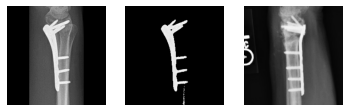

new filepath images_processed/Acumed/acumed ex5 at 10.25.02 AM.png


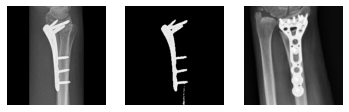

new filepath images_processed/Acumed/Acumed ex2 at 9.50.35 AM.png


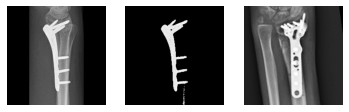

new filepath images_processed/Acumed/Acumed ex2 at 9.50.48 AM.png


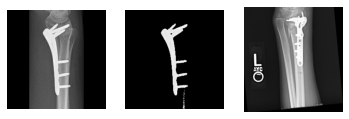

new filepath images_processed/Acumed/acumed ex1 at 9.47.24 AM.png


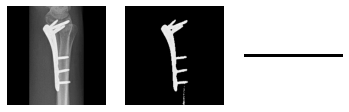

new filepath images_processed/Acumed/Acumed ex2 at 9.50.59 AM (1).png


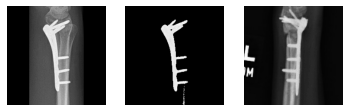

new filepath images_processed/Acumed/acumed ex5 at 10.12.46 AM (1).png


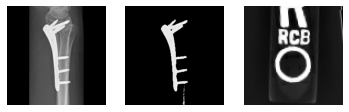

new filepath images_processed/Acumed/acumed ex3 at 2.20.05 PM (2).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



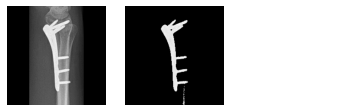

new filepath images_processed/Acumed/Acumed ex2 at 9.50.48 AM (1).png


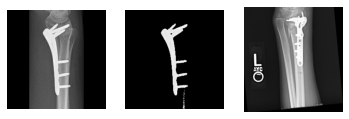

new filepath images_processed/Acumed/acumed ex3 at 9.57.37 AM (1).png


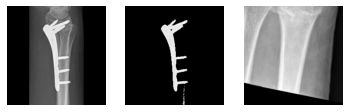

new filepath images_processed/Acumed/acumed ex3 at 9.58.16 AM.png


new filepath images_processed/Acumed/acumed ex5 at 10.25.32 AM (1).png


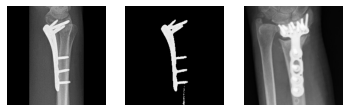

new filepath images_processed/Acumed/acumed ex3 at 9.57.42 AM.png


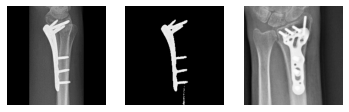

new filepath images_processed/Acumed/Acumed ex2 at 9.50.54 AM (1).png


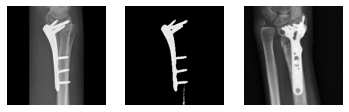

new filepath images_processed/Acumed/acumed ex1 at 9.45.42 AM (1).png


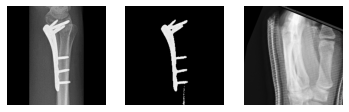

new filepath images_processed/Acumed/acumed ex3 at 9.58.32 AM.png


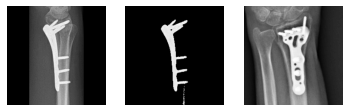

new filepath images_processed/Acumed/acumed ex5 at 10.25.02 AM (1).png


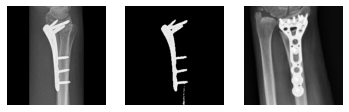

new filepath images_processed/Acumed/acumed ex5 at 10.25.06 AM.png


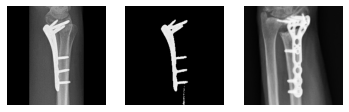

new filepath images_processed/Acumed/acumed ex5 at 10.25.57 AM (1).png


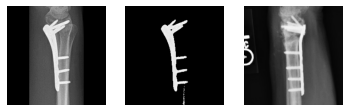

new filepath images_processed/Acumed/acumed ex1 at 2.21.10 PM (3).png


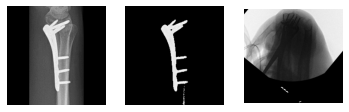

new filepath images_processed/Acumed/acumed ex5 at 10.25.22 AM.png


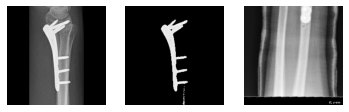

new filepath images_processed/Acumed/acumed ex3 at 9.58.28 AM (1).png


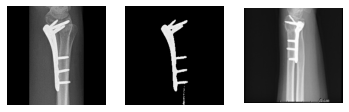

new filepath images_processed/Acumed/acumed ex5 at 10.13.29 AM.png


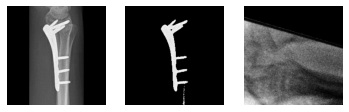

new filepath images_processed/Acumed/acumed ex5 at 10.13.53 AM (1).png


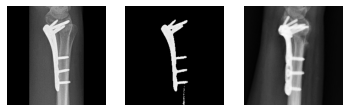

new filepath images_processed/Acumed/acumed ex5 at 10.12.31 AM.png


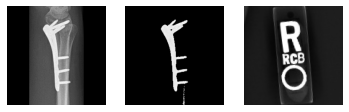

new filepath images_processed/Acumed/acumed ex3 at 9.57.37 AM.png


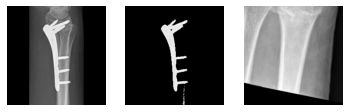

new filepath images_processed/Acumed/acumed ex3 at 9.54.46 AM (1).png


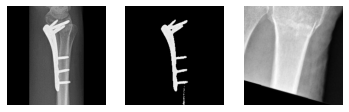

new filepath images_processed/Acumed/acumed ex3 at 9.58.28 AM.png


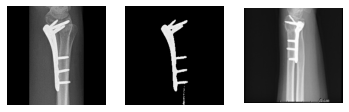

new filepath images_processed/Acumed/acumed ex1 at 2.22.36 PM (2).png


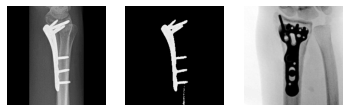

new filepath images_processed/Acumed/acumed ex1 at 9.45.42 AM.png


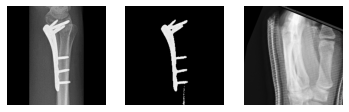

new filepath images_processed/Acumed/acumed ex1 at 9.47.15 AM (2).png


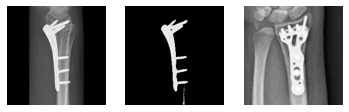

new filepath images_processed/Acumed/acumed ex5 at 10.24.45 AM (1).png


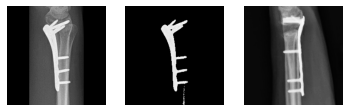

new filepath images_processed/Acumed/Acumed ex2 at 9.50.42 AM (1).png


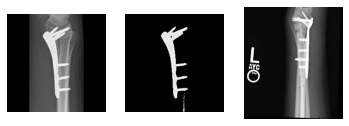

new filepath images_processed/Acumed/acumed ex5 at 10.24.34 AM.png


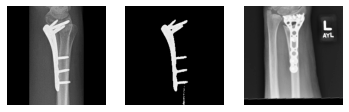

new filepath images_processed/Acumed/acumed ex5 at 10.12.42 AM.png


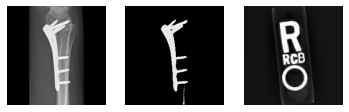

new filepath images_processed/Acumed/acumed ex5 at 10.24.38 AM.png


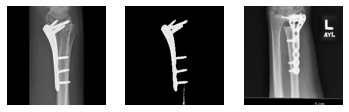

new filepath images_processed/Acumed/acumed ex5 at 10.24.45 AM.png


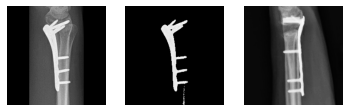

new filepath images_processed/Acumed/acumed ex5 at 10.25.16 AM (1).png


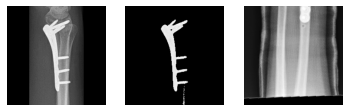

new filepath images_processed/Acumed/acumed ex1 at 9.47.24 AM (1).png


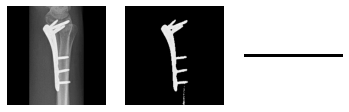

new filepath images_processed/Acumed/acumed ex5 at 10.25.52 AM (1).png


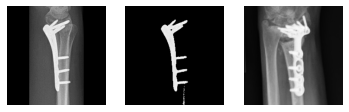

new filepath images_processed/Acumed/Acumed ex2 at 9.50.42 AM.png


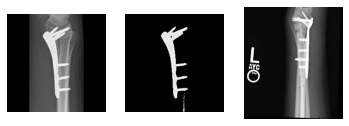

new filepath images_processed/Acumed/acumed ex5 at 10.25.16 AM.png


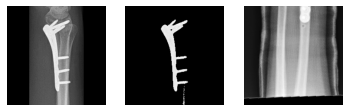

new filepath images_processed/Acumed/acumed ex1 at 2.21.10 PM (2).png


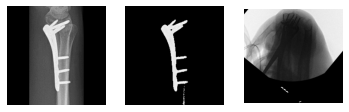

new filepath images_processed/Acumed/acumed ex1 at 2.22.39 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



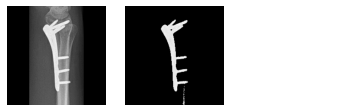

new filepath images_processed/Acumed/acumed ex5 at 10.13.34 AM (1).png


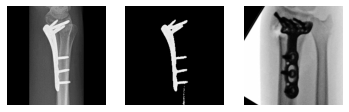

new filepath images_processed/Acumed/acumed ex5 at 10.25.20 AM.png


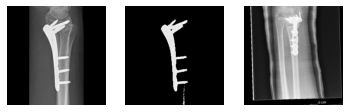

new filepath images_processed/Acumed/acumed ex5 at 10.25.32 AM.png


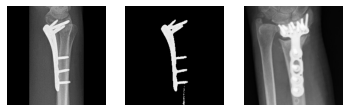

new filepath images_processed/Acumed/Acumed ex2 at 9.50.59 AM.png


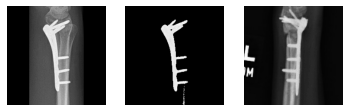

new filepath images_processed/Acumed/acumed ex3 at 9.58.41 AM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



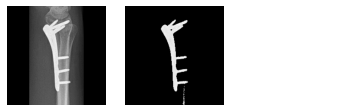

new filepath images_processed/Acumed/acumed ex3 at 9.58.23 AM (1).png


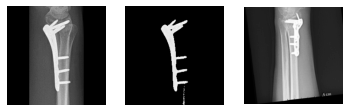

new filepath images_processed/Acumed/acumed ex5 at 10.25.22 AM (1).png


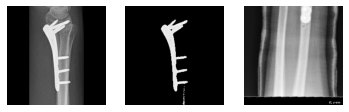

new filepath images_processed/Acumed/acumed ex1 at 9.45.30 AM (1).png


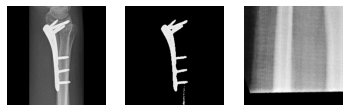

new filepath images_processed/Acumed/acumed ex1 at 2.21.10 PM (1).png


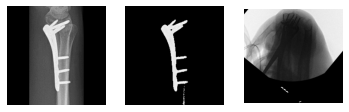

new filepath images_processed/Acumed/acumed ex5 at 10.25.37 AM.png


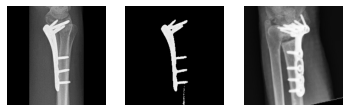

new filepath images_processed/Acumed/acumed ex5 at 10.25.09 AM (1).png


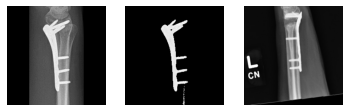

new filepath images_processed/Acumed/acumed ex5 at 10.13.53 AM.png


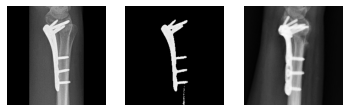

new filepath images_processed/Acumed/Acumed ex2 at 9.51.06 AM.png


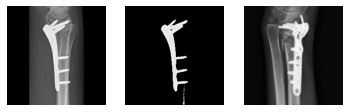

new filepath images_processed/Acumed/acumed ex3 at 9.58.23 AM.png


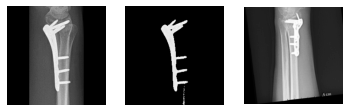

new filepath images_processed/Acumed/acumed ex3 at 9.54.46 AM.png


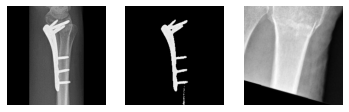

new filepath images_processed/Acumed/acumed ex3 at 9.58.32 AM (1).png


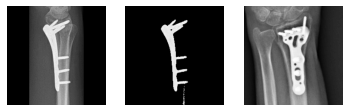

new filepath images_processed/Acumed/acumed ex5 at 10.13.49 AM (1).png


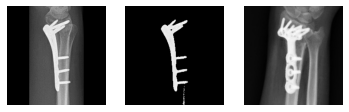

new filepath images_processed/Acumed/acumed ex5 at 10.12.31 AM (1).png


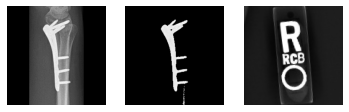

new filepath images_processed/Acumed/acumed ex5 at 10.25.48 AM (1).png


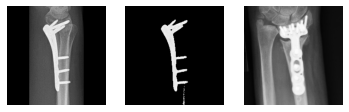

new filepath images_processed/Acumed/acumed ex1 at 2.22.36 PM (1).png


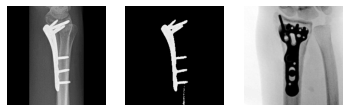

new filepath images_processed/Acumed/acumed ex3 at 9.54.56 AM.png


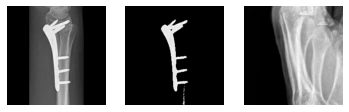

new filepath images_processed/Acumed/acumed ex3 at 9.58.37 AM (1).png


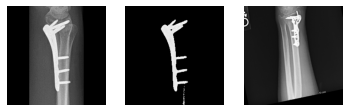

new filepath images_processed/Acumed/acumed ex1 at 9.47.15 AM (1).png


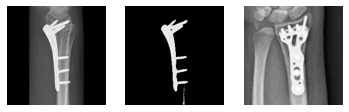

new filepath images_processed/Acumed/Acumed ex2 at 9.51.06 AM (1).png


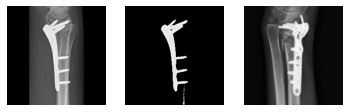

new filepath images_processed/Acumed/acumed ex1 at 9.45.35 AM (1).png


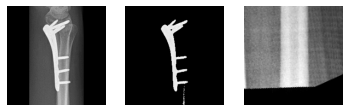

new filepath images_processed/Acumed/acumed ex3 at 2.20.02 PM (1).png


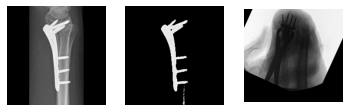

new filepath images_processed/Acumed/acumed ex5 at 10.12.42 AM (1).png


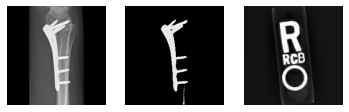

new filepath images_processed/Acumed/acumed ex5 at 10.24.38 AM (1).png


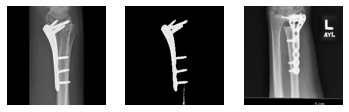

new filepath images_processed/Acumed/acumed ex5 at 10.13.43 AM.png


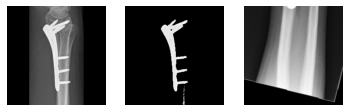

new filepath images_processed/Acumed/acumed ex5 at 10.25.48 AM.png


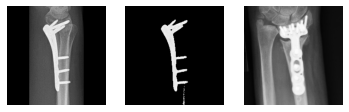

new filepath images_processed/Acumed/acumed ex3 at 2.20.05 PM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



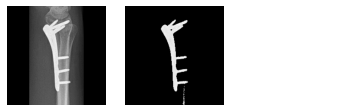

new filepath images_processed/Acumed/acumed ex1 at 2.22.42 PM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



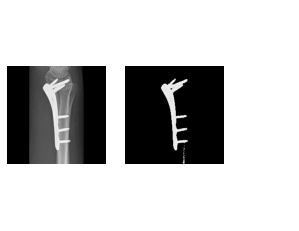

new filepath images_processed/Acumed/acumed ex5 at 10.13.38 AM (1).png


new filepath images_processed/Acumed/acumed ex3 at 9.58.37 AM.png


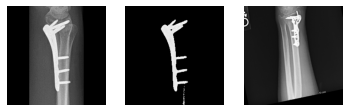

new filepath images_processed/Acumed/acumed ex5 at 10.25.42 AM (1).png


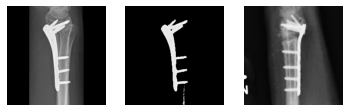

new filepath images_processed/Acumed/acumed ex5 at 10.25.20 AM (1).png


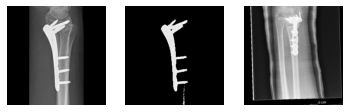

new filepath images_processed/Acumed/acumed ex3 at 9.58.16 AM (1).png


new filepath images_processed/Acumed/acumed ex1 at 9.45.42 AM (2).png


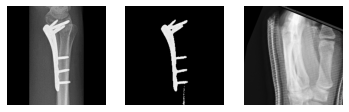

new filepath images_processed/Acumed/acumed ex5 at 10.25.52 AM.png


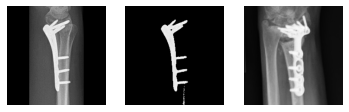

new filepath images_processed/Acumed/Acumed ex2 at 9.50.35 AM (1).png


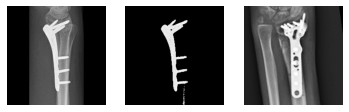

new filepath images_processed/Acumed/acumed ex1 at 2.22.36 PM.png


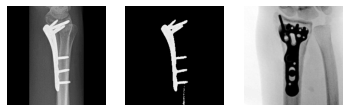

new filepath images_processed/Acumed/acumed ex5 at 10.25.06 AM (1).png


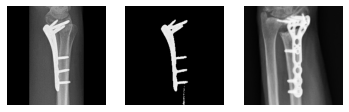

new filepath images_processed/Acumed/acumed ex5 at 10.13.29 AM (1).png


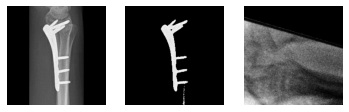

new filepath images_processed/Acumed/acumed ex3 at 2.19.58 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



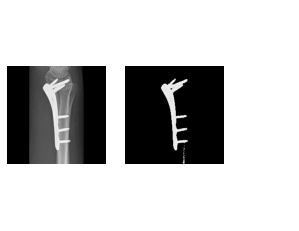

new filepath images_processed/Acumed/acumed ex1 at 9.47.19 AM.png


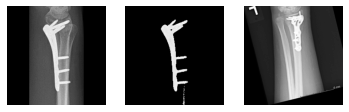

new filepath images_processed/Acumed/acumed ex3 at 2.20.05 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



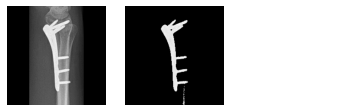

new filepath images_processed/Acumed/acumed ex5 at 10.13.34 AM.png


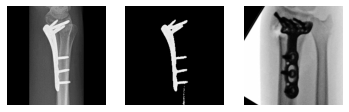

new filepath images_processed/Acumed/acumed ex5 at 10.13.49 AM.png


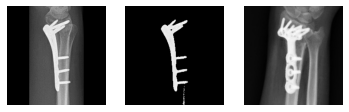

new filepath images_processed/Acumed/acumed ex5 at 10.25.42 AM.png


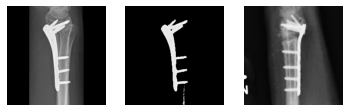

new filepath images_processed/Acumed/acumed ex5 at 10.13.38 AM.png


new filepath images_processed/Acumed/acumed ex3 at 2.19.58 PM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



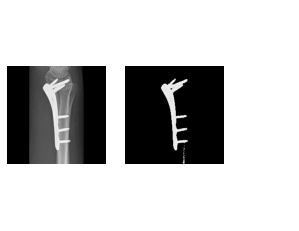

new filepath images_processed/Acumed/acumed ex1 at 9.47.15 AM.png


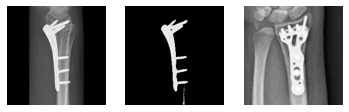

new filepath images_processed/Acumed/acumed ex3 at 9.54.56 AM (1).png


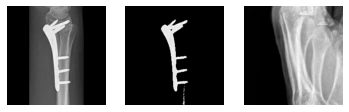

new filepath images_processed/Acumed/acumed ex5 at 10.25.09 AM.png


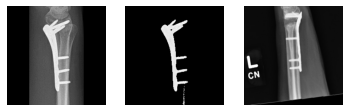

new filepath images_processed/Acumed/acumed ex3 at 9.57.42 AM (1).png


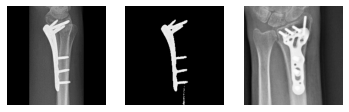

new filepath images_processed/Acumed/acumed ex5 at 10.13.43 AM (1).png


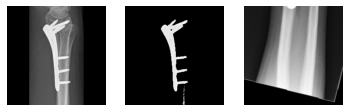

new filepath images_processed/Acumed/acumed ex1 at 2.22.39 PM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



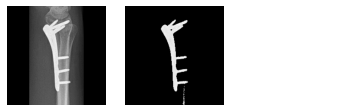

new filepath images_processed/Acumed/acumed ex1 at 9.45.30 AM.png


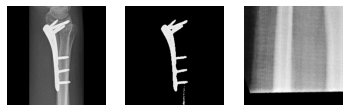

new filepath images_processed/total/synthes va ex5 at 10.56.45 AM.png


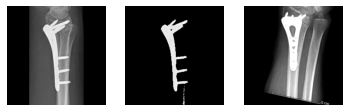

new filepath images_processed/total/acumed ex3 at 9.58.41 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



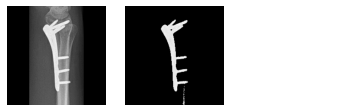

new filepath images_processed/total/synthes va ex1-6 (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



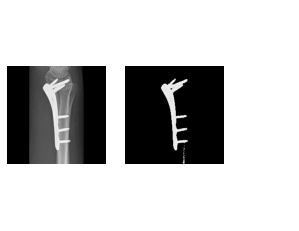

new filepath images_processed/total/synthes va ex5 at 10.57.20 AM.png


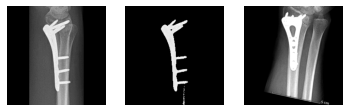

new filepath images_processed/total/Acumed ex2 at 9.50.54 AM.png


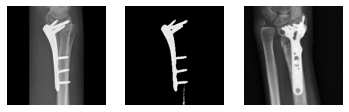

new filepath images_processed/total/synthes va ex3 at 4.31.49 AM.png


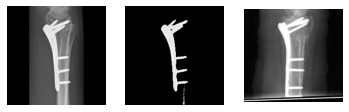

new filepath images_processed/total/acumed ex5 at 10.25.26 AM.png


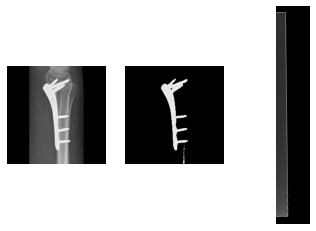

new filepath images_processed/total/acumed ex5 at 10.25.57 AM.png


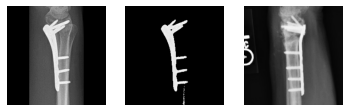

new filepath images_processed/total/synthes va ex5 at 2.29.37 PM.png


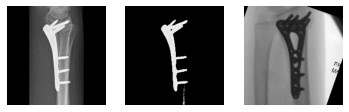

new filepath images_processed/total/acumed ex5 at 10.25.02 AM.png


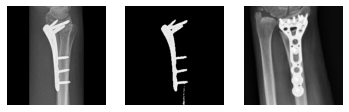

new filepath images_processed/total/Acumed ex2 at 9.50.35 AM.png


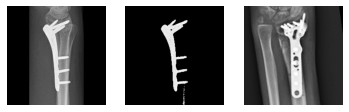

new filepath images_processed/total/Acumed ex2 at 9.50.48 AM.png


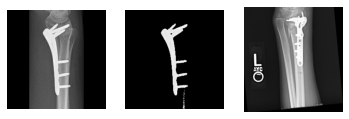

new filepath images_processed/total/acumed ex1 at 9.47.24 AM.png


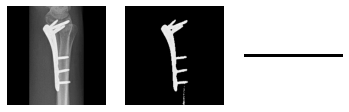

new filepath images_processed/total/synthes va ex5 at 2.29.29 PM.png


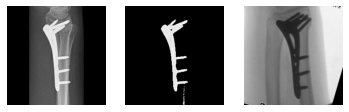

new filepath images_processed/total/synthes va ex3 at 4.31.59 AM.png


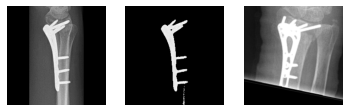

new filepath images_processed/total/synthes va ex2 at 4.18.23 AM.png


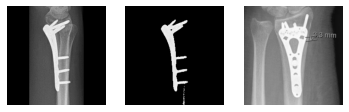

new filepath images_processed/total/acumed ex3 at 9.58.16 AM.png


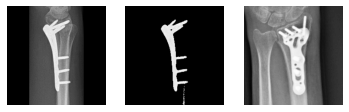

new filepath images_processed/total/acumed ex3 at 9.57.42 AM.png


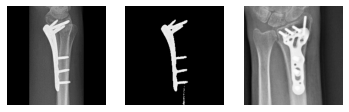

new filepath images_processed/total/synthes va ex5 at 10.56.24 AM.png


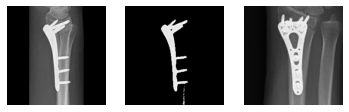

new filepath images_processed/total/acumed ex3 at 9.58.32 AM.png


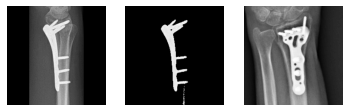

new filepath images_processed/total/trimed va ex1 at 4.07.05 AM.png


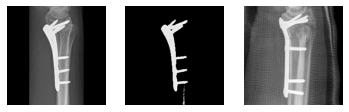

new filepath images_processed/total/synthes va ex3 at 4.35.19 AM.png


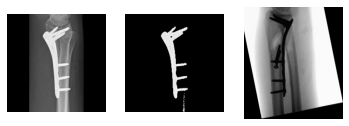

new filepath images_processed/total/synthes va ex5 at 2.29.33 PM.png


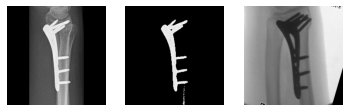

new filepath images_processed/total/acumed ex5 at 10.25.06 AM.png


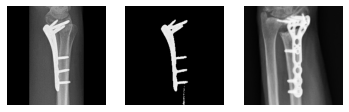

new filepath images_processed/total/synthes va ex5 at 2.29.50 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



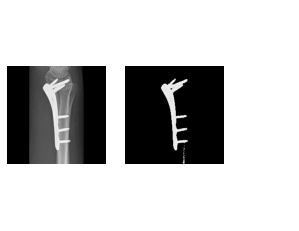

new filepath images_processed/total/acumed ex5 at 10.25.22 AM.png


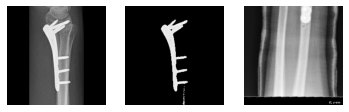

new filepath images_processed/total/acumed ex5 at 10.13.29 AM.png


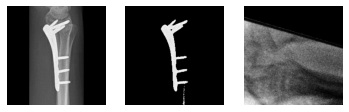

new filepath images_processed/total/synthes va ex1-8.png


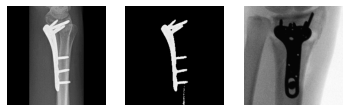

new filepath images_processed/total/acumed ex3 at 9.58.28 AM.png


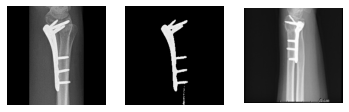

new filepath images_processed/total/synthes va ex5 at 10.56.32 AM.png


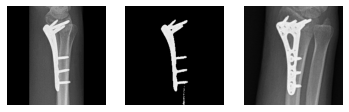

new filepath images_processed/total/synthes va ex1-9.png


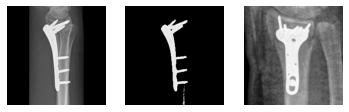

new filepath images_processed/total/synthes va ex2 at 4.18.48 AM.png


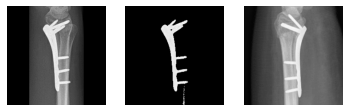

new filepath images_processed/total/acumed ex5 at 10.24.34 AM.png


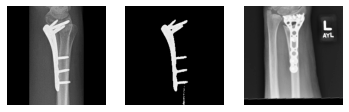

new filepath images_processed/total/acumed ex5 at 10.24.38 AM.png


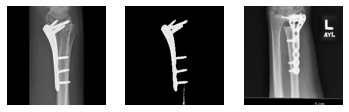

new filepath images_processed/total/acumed ex5 at 10.24.45 AM.png


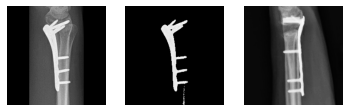

new filepath images_processed/total/synthes va ex3 at 4.31.53 AM.png


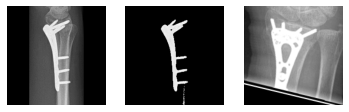

new filepath images_processed/total/synthes va ex3 at 4.31.30 AM.png


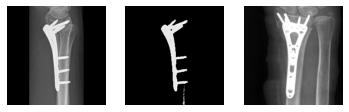

new filepath images_processed/total/Acumed ex2 at 9.50.42 AM.png


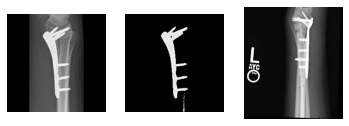

new filepath images_processed/total/acumed ex5 at 10.25.16 AM.png


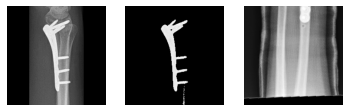

new filepath images_processed/total/acumed ex1 at 2.22.39 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



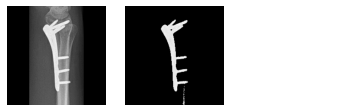

new filepath images_processed/total/acumed ex5 at 10.25.20 AM.png


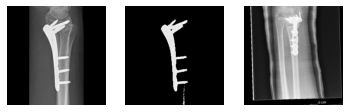

new filepath images_processed/total/acumed ex5 at 10.25.32 AM.png


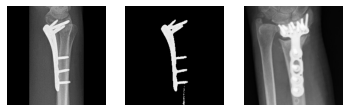

new filepath images_processed/total/Acumed ex2 at 9.50.59 AM.png


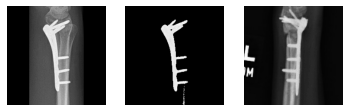

new filepath images_processed/total/synthes va ex5 at 2.29.26 PM.png


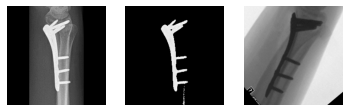

new filepath images_processed/total/synthes va ex5 at 2.29.45 PM.png


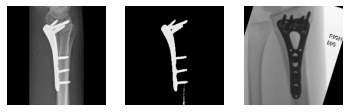

new filepath images_processed/total/synthes va ex3 at 4.31.35 AM.png


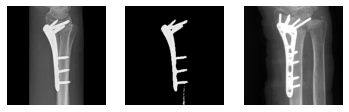

new filepath images_processed/total/trimed va ex1 at 4.06.59 AM.png


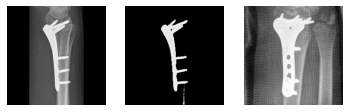

new filepath images_processed/total/synthes va ex5 at 2.29.57 PM.png


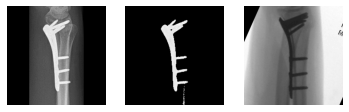

new filepath images_processed/total/acumed ex5 at 10.25.37 AM.png


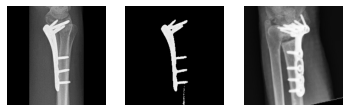

new filepath images_processed/total/acumed ex5 at 10.13.53 AM.png


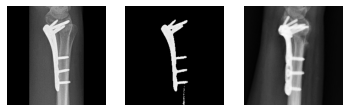

new filepath images_processed/total/synthes va ex5 at 2.29.10 PM.png


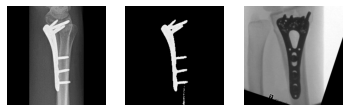

new filepath images_processed/total/synthes va ex2 at 4.18.04 AM.png


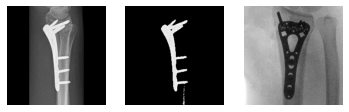

new filepath images_processed/total/synthes va ex5 at 10.56.35 AM.png


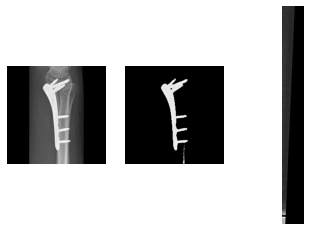

new filepath images_processed/total/synthes va ex2 at 4.18.08 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



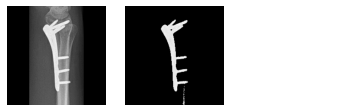

new filepath images_processed/total/Acumed ex2 at 9.51.06 AM.png


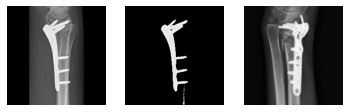

new filepath images_processed/total/acumed ex3 at 9.58.23 AM.png


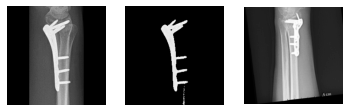

new filepath images_processed/total/synthes va ex5 at 10.56.54 AM.png


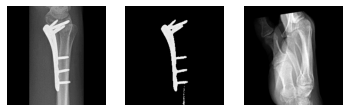

new filepath images_processed/total/synthes va ex1-7.png


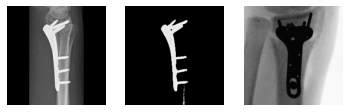

new filepath images_processed/total/trimed va ex1 at 4.06.49 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



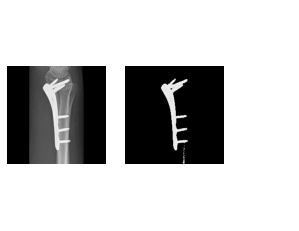

new filepath images_processed/total/synthes va ex5 at 2.22.45 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



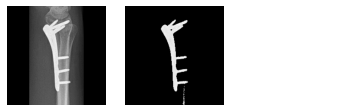

new filepath images_processed/total/acumed ex5 at 10.13.43 AM.png


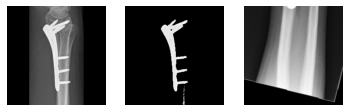

new filepath images_processed/total/acumed ex5 at 10.25.48 AM.png


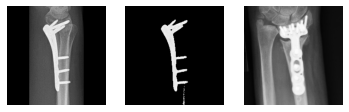

new filepath images_processed/total/synthes va ex1-6.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



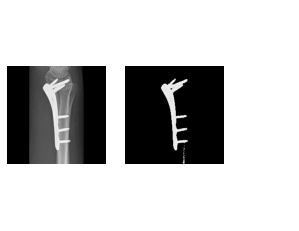

new filepath images_processed/total/acumed ex3 at 9.58.37 AM.png


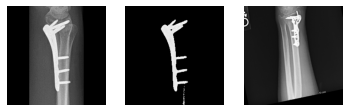

new filepath images_processed/total/synthes va ex1-14.png


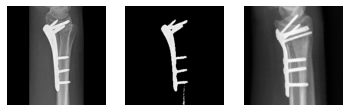

new filepath images_processed/total/synthes va ex5 at 10.56.50 AM.png


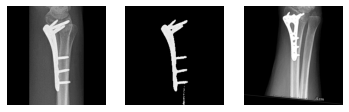

new filepath images_processed/total/acumed ex5 at 10.25.52 AM.png


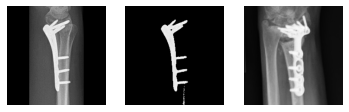

new filepath images_processed/total/acumed ex1 at 2.22.36 PM.png


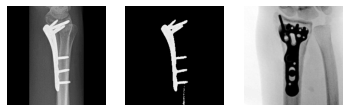

new filepath images_processed/total/synthes va ex3 at 4.35.14 AM.png


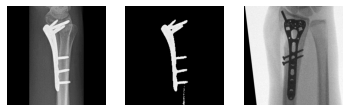

new filepath images_processed/total/synthes va ex5 at 2.29.20 PM.png


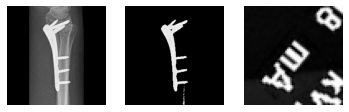

new filepath images_processed/total/acumed ex3 at 2.19.58 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



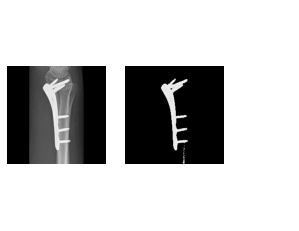

new filepath images_processed/total/synthes va ex3 at 4.31.15 AM.png


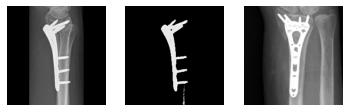

new filepath images_processed/total/acumed ex1 at 9.47.19 AM.png


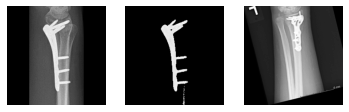

new filepath images_processed/total/acumed ex3 at 2.20.05 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



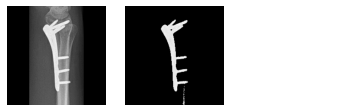

new filepath images_processed/total/acumed ex5 at 10.13.34 AM.png


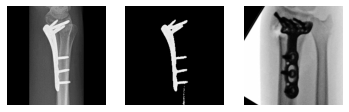

new filepath images_processed/total/acumed ex5 at 10.13.49 AM.png


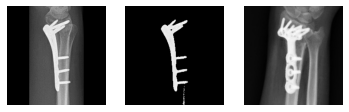

new filepath images_processed/total/acumed ex5 at 10.25.42 AM.png


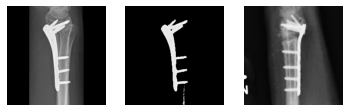

new filepath images_processed/total/acumed ex5 at 10.13.38 AM.png


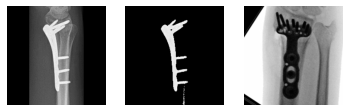

new filepath images_processed/total/acumed ex1 at 9.47.15 AM.png


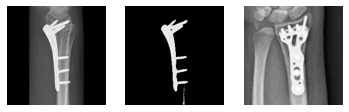

new filepath images_processed/total/synthes va ex1-13.png


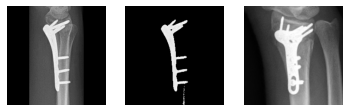

new filepath images_processed/total/synthes va ex3 at 4.31.19 AM.png


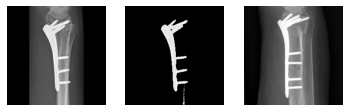

new filepath images_processed/total/synthes va ex1-12.png


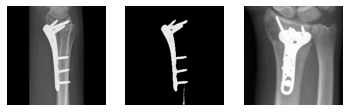

new filepath images_processed/total/synthes va ex5 at 2.29.53 PM.png


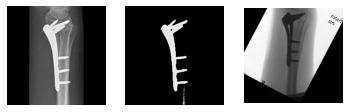

new filepath images_processed/total/synthes va ex3 at 4.31.23 AM.png


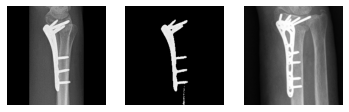

new filepath images_processed/total/acumed ex5 at 10.25.09 AM.png


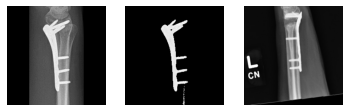

new filepath images_processed/total/synthes va ex3 at 4.31.40 AM.png


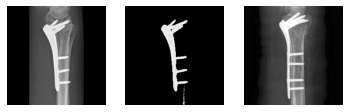

new filepath images_processed/total/synthes va ex2 at 4.18.36 AM.png


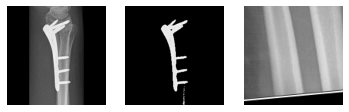

new filepath images_processed/total/synthes va ex1-10.png


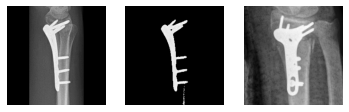

new filepath images_processed/total/synthes va ex1-11.png


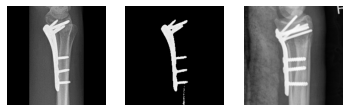

new filepath images_processed/total/synthes va ex5 at 10.56.40 AM.png


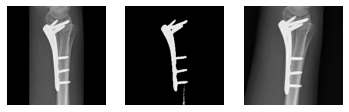

new filepath images_processed/Synthes/synthes va ex3 at 4.30.58 AM (1).png


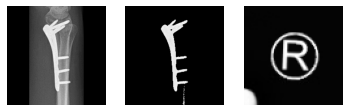

new filepath images_processed/Synthes/synthes va ex3 at 4.34.44 AM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



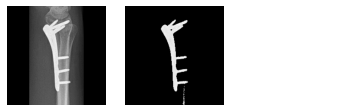

new filepath images_processed/Synthes/synthes va ex5 at 2.29.29 PM (1).png


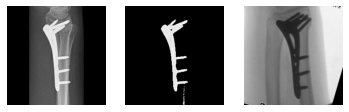

new filepath images_processed/Synthes/synthes va ex3 at 4.34.40 AM.png


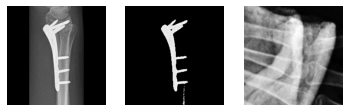

new filepath images_processed/Synthes/synthes va ex5 at 10.56.45 AM.png


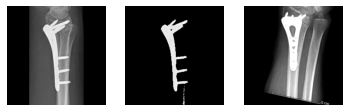

new filepath images_processed/Synthes/synthes va ex5 at 2.29.57 PM (1).png


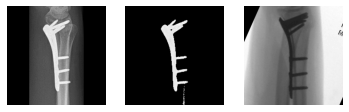

new filepath images_processed/Synthes/synthes va ex3 at 4.30.04 AM.png


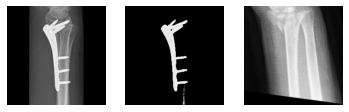

new filepath images_processed/Synthes/synthes va ex1-6 (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



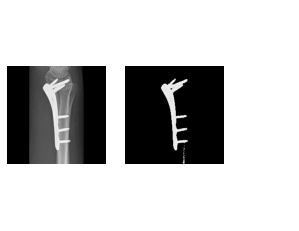

new filepath images_processed/Synthes/synthes va ex5 at 10.57.20 AM.png


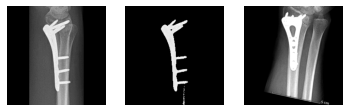

new filepath images_processed/Synthes/synthes va ex5 at 10.54.44 AM.png


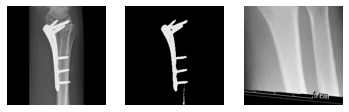

new filepath images_processed/Synthes/synthes va ex3 at 4.31.49 AM.png


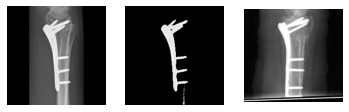

new filepath images_processed/Synthes/synthes va ex3 at 4.31.53 AM (1).png


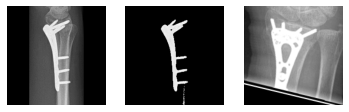

new filepath images_processed/Synthes/synthes va ex1-7 (1).png


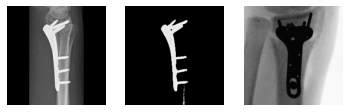

new filepath images_processed/Synthes/synthes va ex5 at 2.29.37 PM.png


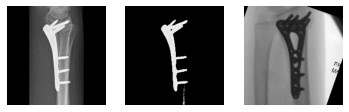

new filepath images_processed/Synthes/synthes va ex3 at 4.35.14 AM (2).png


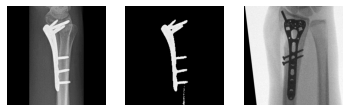

new filepath images_processed/Synthes/synthes va ex5 at 2.29.29 PM.png


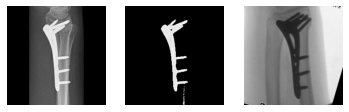

new filepath images_processed/Synthes/synthes va ex3 at 4.31.59 AM.png


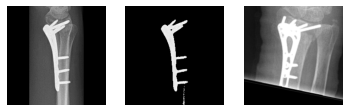

new filepath images_processed/Synthes/synthes va ex5 at 10.54.44 AM (1).png


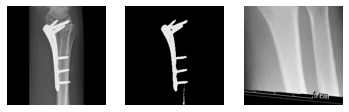

new filepath images_processed/Synthes/synthes va ex2 at 4.18.23 AM.png


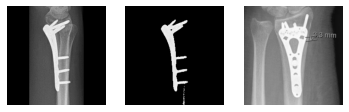

new filepath images_processed/Synthes/synthes va ex5 at 10.54.26 AM (1).png


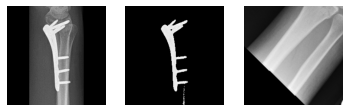

new filepath images_processed/Synthes/synthes va ex3 at 4.30.30 AM.png


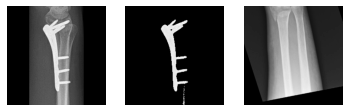

new filepath images_processed/Synthes/synthes va ex3 at 4.30.18 AM.png


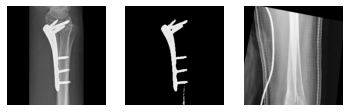

new filepath images_processed/Synthes/synthes va ex5 at 10.56.24 AM.png


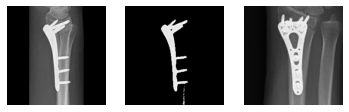

new filepath images_processed/Synthes/synthes va ex1-5 (1).png


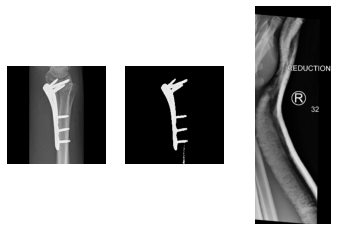

new filepath images_processed/Synthes/synthes va ex3 at 4.35.19 AM.png


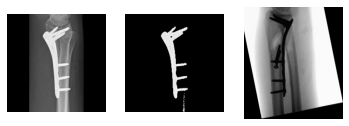

new filepath images_processed/Synthes/synthes va ex5 at 2.29.33 PM.png


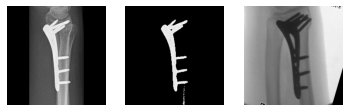

new filepath images_processed/Synthes/synthes va ex5 at 2.29.50 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



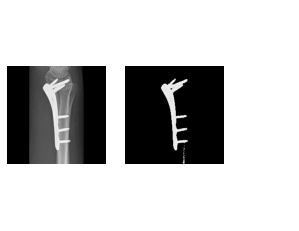

new filepath images_processed/Synthes/synthes va ex5 at 10.54.33 AM.png


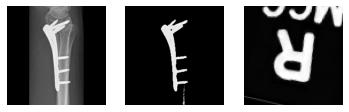

new filepath images_processed/Synthes/synthes va ex3 at 4.35.07 AM.png


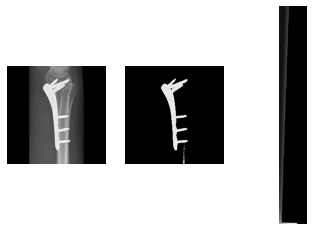

new filepath images_processed/Synthes/synthes va ex5 at 2.29.37 PM (1).png


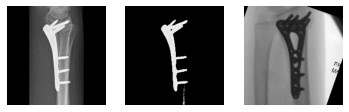

new filepath images_processed/Synthes/synthes va ex3 at 4.31.59 AM (1).png


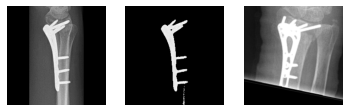

new filepath images_processed/Synthes/synthes va ex5 at 10.56.45 AM (1).png


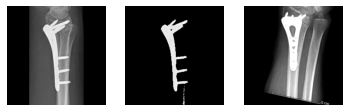

new filepath images_processed/Synthes/synthes va ex1-8.png


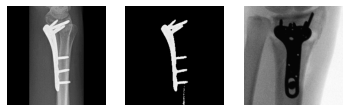

new filepath images_processed/Synthes/synthes va ex1-14 (1).png


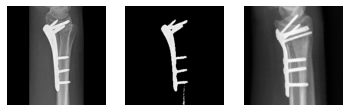

new filepath images_processed/Synthes/synthes va ex5 at 10.56.54 AM (1).png


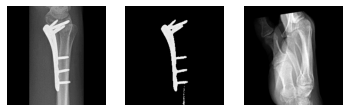

new filepath images_processed/Synthes/synthes va ex5 at 10.56.32 AM.png


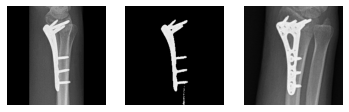

new filepath images_processed/Synthes/synthes va ex5 at 2.29.26 PM (1).png


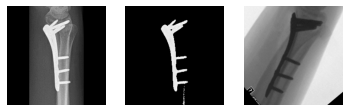

new filepath images_processed/Synthes/synthes va ex3 at 4.30.34 AM.png


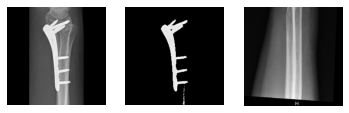

new filepath images_processed/Synthes/synthes va ex3 at 4.30.45 AM.png


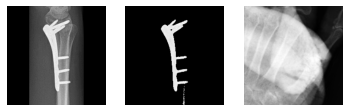

new filepath images_processed/Synthes/synthes va ex1-9.png


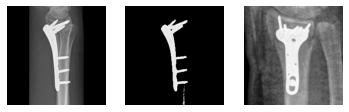

new filepath images_processed/Synthes/synthes va ex2 at 4.18.48 AM.png


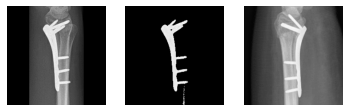

new filepath images_processed/Synthes/synthes va ex3 at 4.35.04 AM (1).png


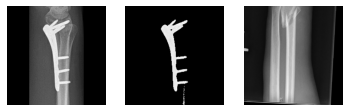

new filepath images_processed/Synthes/synthes va ex3 at 4.34.56 AM.png


new filepath images_processed/Synthes/synthes va ex3 at 4.30.12 AM.png


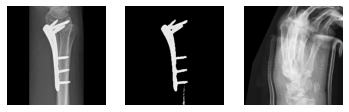

new filepath images_processed/Synthes/synthes va ex3 at 4.34.44 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



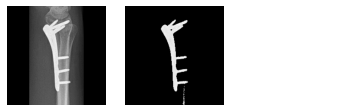

new filepath images_processed/Synthes/synthes va ex3 at 4.30.30 AM (1).png


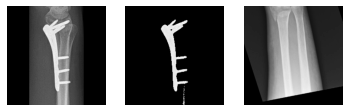

new filepath images_processed/Synthes/synthes va ex5 at 2.22.45 PM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



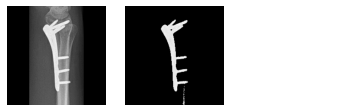

new filepath images_processed/Synthes/synthes va ex5 at 2.29.50 PM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



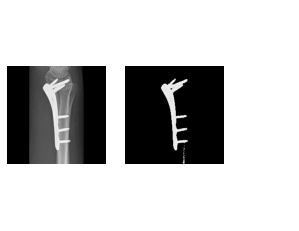

new filepath images_processed/Synthes/synthes va ex3 at 4.31.53 AM.png


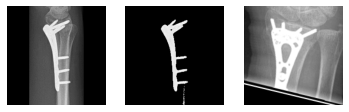

new filepath images_processed/Synthes/synthes va ex1-4 (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



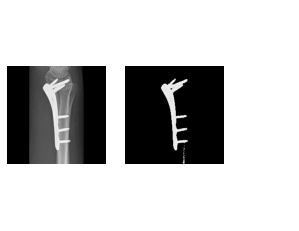

new filepath images_processed/Synthes/synthes va ex2 at 4.18.08 AM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



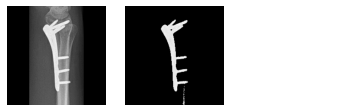

new filepath images_processed/Synthes/synthes va ex3 at 4.31.30 AM.png


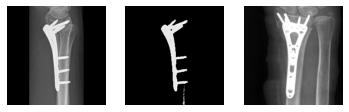

new filepath images_processed/Synthes/synthes va ex3 at 4.31.15 AM (1).png


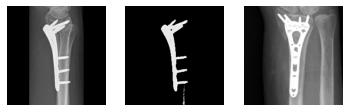

new filepath images_processed/Synthes/synthes va ex3 at 4.31.40 AM (1).png


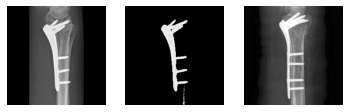

new filepath images_processed/Synthes/synthes va ex5 at 10.56.40 AM (1).png


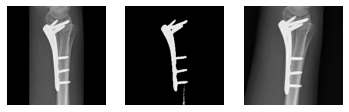

new filepath images_processed/Synthes/synthes va ex2 at 4.18.23 AM (1).png


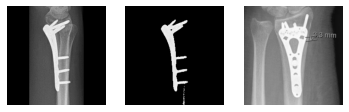

new filepath images_processed/Synthes/synthes va ex5 at 2.29.20 PM (1).png


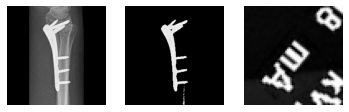

new filepath images_processed/Synthes/synthes va ex5 at 2.29.26 PM.png


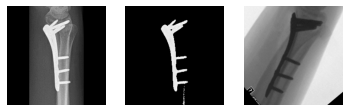

new filepath images_processed/Synthes/synthes va ex1-2.png


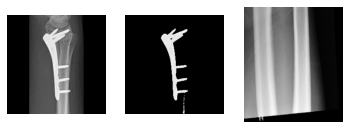

new filepath images_processed/Synthes/synthes va ex5 at 2.29.45 PM.png


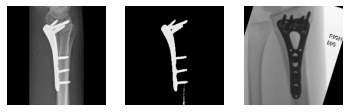

new filepath images_processed/Synthes/synthes va ex5 at 10.54.26 AM.png


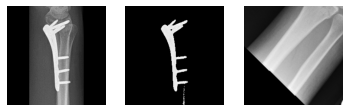

new filepath images_processed/Synthes/synthes va ex3 at 4.30.04 AM (1).png


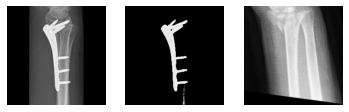

new filepath images_processed/Synthes/synthes va ex3 at 4.31.35 AM.png


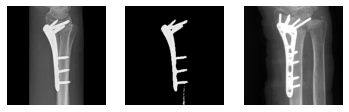

new filepath images_processed/Synthes/synthes va ex5 at 2.29.57 PM.png


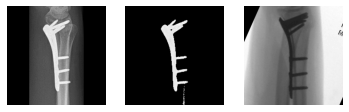

new filepath images_processed/Synthes/synthes va ex3 at 4.31.30 AM (1).png


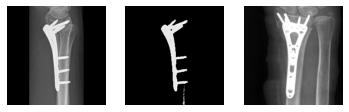

new filepath images_processed/Synthes/synthes va ex3 at 4.35.00 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



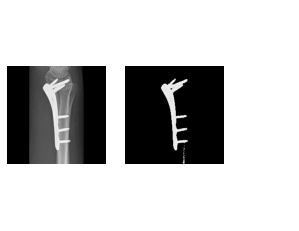

new filepath images_processed/Synthes/synthes va ex1-1 (1).png


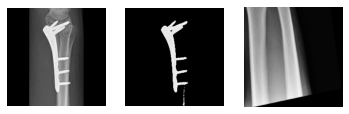

new filepath images_processed/Synthes/synthes va ex5 at 2.29.10 PM.png


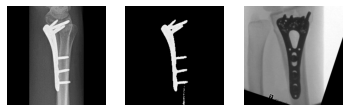

new filepath images_processed/Synthes/synthes va ex3 at 4.35.07 AM (1).png


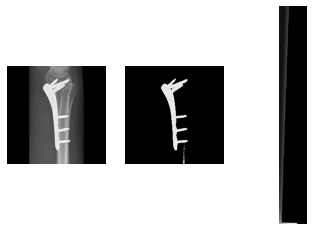

new filepath images_processed/Synthes/synthes va ex3 at 4.30.18 AM (1).png


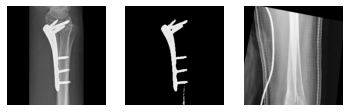

new filepath images_processed/Synthes/synthes va ex1-3.png


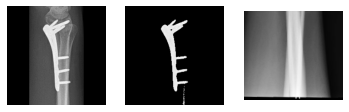

new filepath images_processed/Synthes/synthes va ex1-1.png


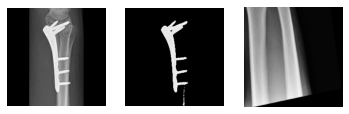

new filepath images_processed/Synthes/synthes va ex3 at 4.34.40 AM (1).png


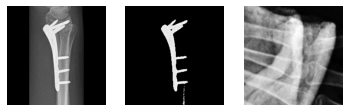

new filepath images_processed/Synthes/synthes va ex2 at 4.18.04 AM.png


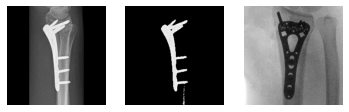

new filepath images_processed/Synthes/synthes va ex5 at 10.56.35 AM.png


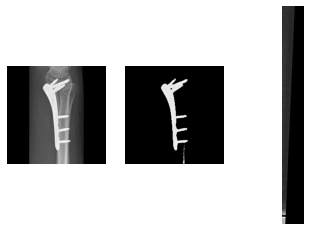

new filepath images_processed/Synthes/synthes va ex2 at 4.18.08 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



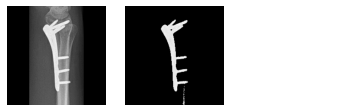

new filepath images_processed/Synthes/synthes va ex1-10 (1).png


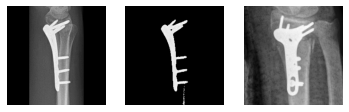

new filepath images_processed/Synthes/synthes va ex1-8 (1).png


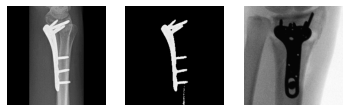

new filepath images_processed/Synthes/synthes va ex5 at 2.29.53 PM (1).png


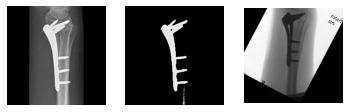

new filepath images_processed/Synthes/synthes va ex5 at 10.56.54 AM.png


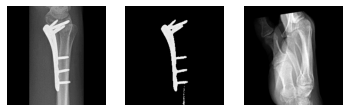

new filepath images_processed/Synthes/synthes va ex1-4.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



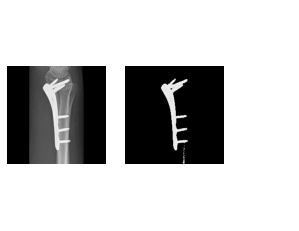

new filepath images_processed/Synthes/synthes va ex5 at 10.56.24 AM (1).png


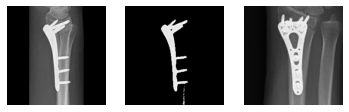

new filepath images_processed/Synthes/synthes va ex1-11 (1).png


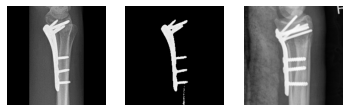

new filepath images_processed/Synthes/synthes va ex3 at 4.30.45 AM (1).png


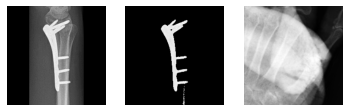

new filepath images_processed/Synthes/synthes va ex1-9 (1).png


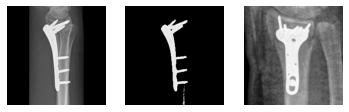

new filepath images_processed/Synthes/synthes va ex1-5.png


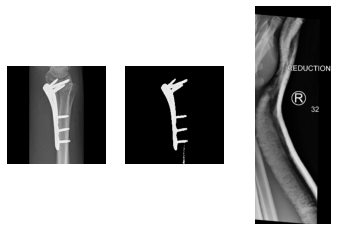

new filepath images_processed/Synthes/synthes va ex1-7.png


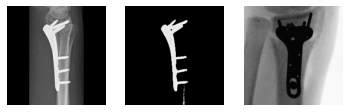

new filepath images_processed/Synthes/synthes va ex3 at 4.30.54 AM (1).png


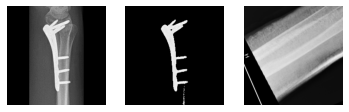

new filepath images_processed/Synthes/synthes va ex3 at 4.31.35 AM (1).png


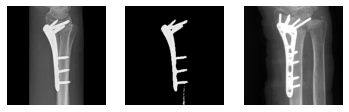

new filepath images_processed/Synthes/synthes va ex5 at 2.22.45 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



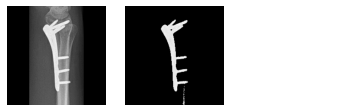

new filepath images_processed/Synthes/synthes va ex5 at 10.54.33 AM (1).png


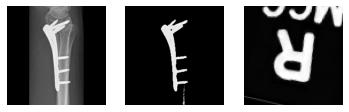

new filepath images_processed/Synthes/synthes va ex5 at 10.56.35 AM (1).png


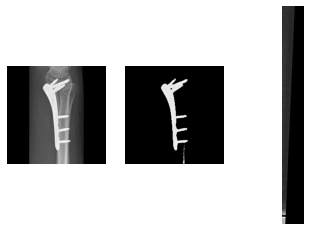

new filepath images_processed/Synthes/synthes va ex1-6.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



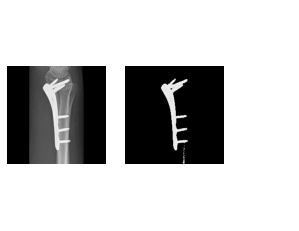

new filepath images_processed/Synthes/synthes va ex5 at 10.56.32 AM (1).png


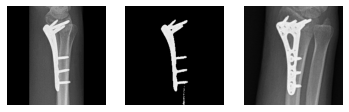

new filepath images_processed/Synthes/synthes va ex2 at 4.18.04 AM (1).png


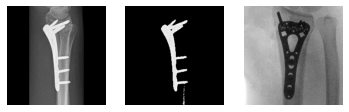

new filepath images_processed/Synthes/synthes va ex5 at 10.56.50 AM (1).png


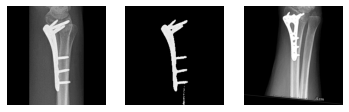

new filepath images_processed/Synthes/synthes va ex3 at 4.31.19 AM (1).png


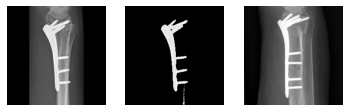

new filepath images_processed/Synthes/synthes va ex3 at 4.34.47 AM.png


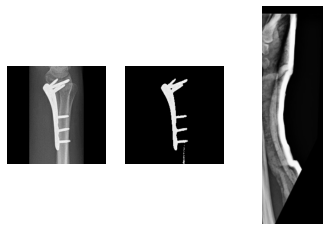

new filepath images_processed/Synthes/synthes va ex1-14.png


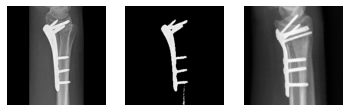

new filepath images_processed/Synthes/synthes va ex3 at 4.35.19 AM (1).png


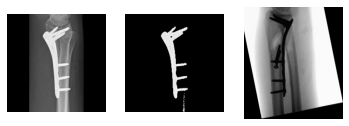

new filepath images_processed/Synthes/synthes va ex5 at 10.56.50 AM.png


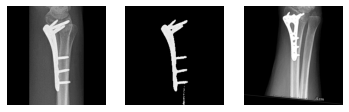

new filepath images_processed/Synthes/synthes va ex1-13 (1).png


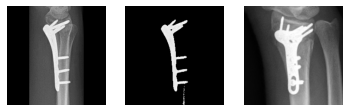

new filepath images_processed/Synthes/synthes va ex3 at 4.31.23 AM (1).png


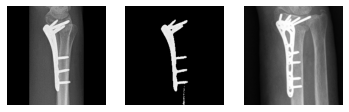

new filepath images_processed/Synthes/synthes va ex5 at 2.29.33 PM (1).png


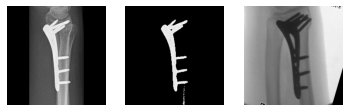

new filepath images_processed/Synthes/synthes va ex3 at 4.35.14 AM.png


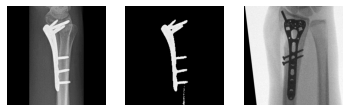

new filepath images_processed/Synthes/synthes va ex5 at 2.29.20 PM.png


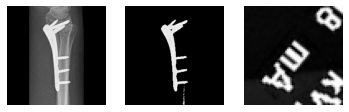

new filepath images_processed/Synthes/synthes va ex3 at 4.35.14 AM (1).png


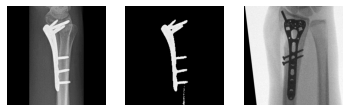

new filepath images_processed/Synthes/synthes va ex5 at 10.57.20 AM (1).png


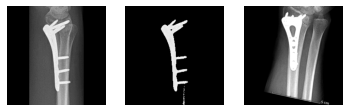

new filepath images_processed/Synthes/synthes va ex1-2 (1).png


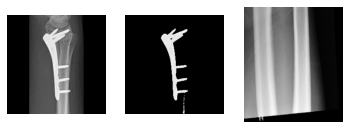

new filepath images_processed/Synthes/synthes va ex3 at 4.31.15 AM.png


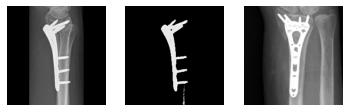

new filepath images_processed/Synthes/synthes va ex1-13.png


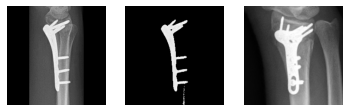

new filepath images_processed/Synthes/synthes va ex3 at 4.31.19 AM.png


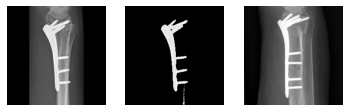

new filepath images_processed/Synthes/synthes va ex3 at 4.30.12 AM (1).png


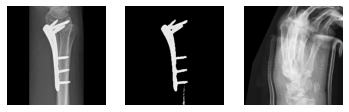

new filepath images_processed/Synthes/synthes va ex1-12.png


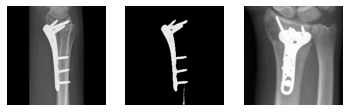

new filepath images_processed/Synthes/synthes va ex3 at 4.35.04 AM.png


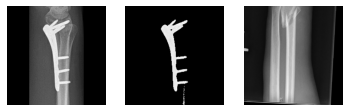

new filepath images_processed/Synthes/synthes va ex5 at 2.29.53 PM.png


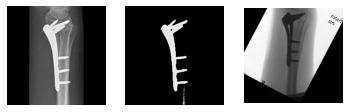

new filepath images_processed/Synthes/synthes va ex3 at 4.31.23 AM.png


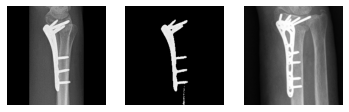

new filepath images_processed/Synthes/synthes va ex1-3 (1).png


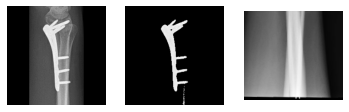

new filepath images_processed/Synthes/synthes va ex3 at 4.31.40 AM.png


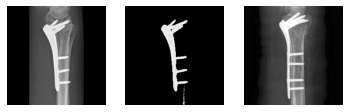

new filepath images_processed/Synthes/synthes va ex3 at 4.34.47 AM (1).png


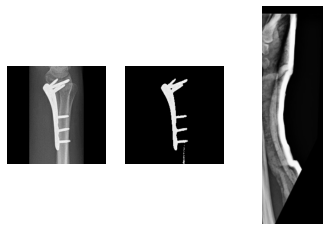

new filepath images_processed/Synthes/synthes va ex3 at 4.34.56 AM (1).png


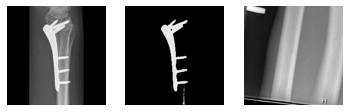

new filepath images_processed/Synthes/synthes va ex3 at 4.31.49 AM (1).png


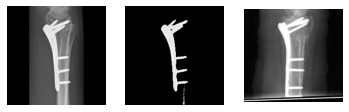

new filepath images_processed/Synthes/synthes va ex3 at 4.35.00 AM (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



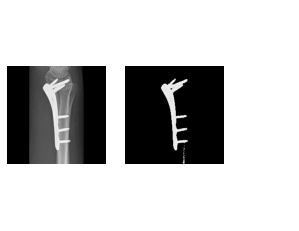

new filepath images_processed/Synthes/synthes va ex2 at 4.18.36 AM.png


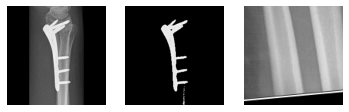

new filepath images_processed/Synthes/synthes va ex3 at 4.30.58 AM.png


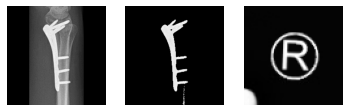

new filepath images_processed/Synthes/synthes va ex2 at 4.18.36 AM (1).png


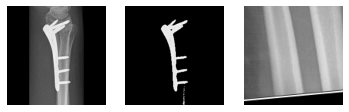

new filepath images_processed/Synthes/synthes va ex3 at 4.30.54 AM.png


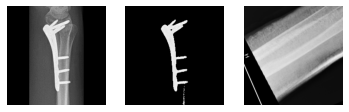

new filepath images_processed/Synthes/synthes va ex1-10.png


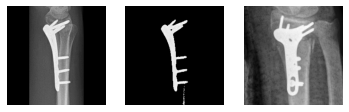

new filepath images_processed/Synthes/synthes va ex3 at 4.30.34 AM (1).png


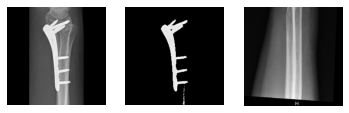

new filepath images_processed/Synthes/synthes va ex1-11.png


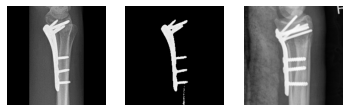

new filepath images_processed/Synthes/synthes va ex1-12 (1).png


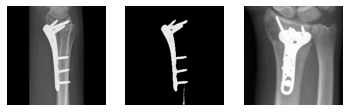

new filepath images_processed/Synthes/synthes va ex5 at 2.29.10 PM (1).png


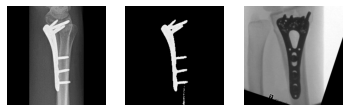

new filepath images_processed/Synthes/synthes va ex5 at 2.29.45 PM (1).png


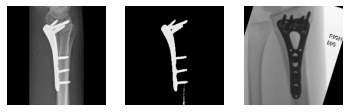

new filepath images_processed/Synthes/synthes va ex5 at 10.56.40 AM.png


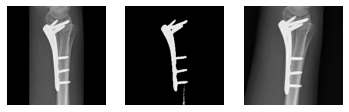

new filepath images_processed/Synthes/synthes va ex2 at 4.18.48 AM (1).png


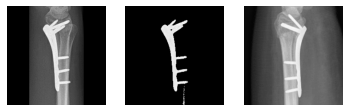

new filepath images_processed/cropped/synthes va ex5 at 10.56.45 AM.png


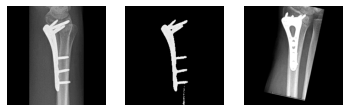

new filepath images_processed/cropped/acumed ex3 at 9.58.41 AM.png


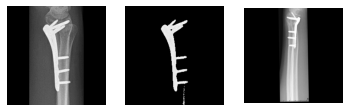

new filepath images_processed/cropped/synthes va ex1-6 (1).png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



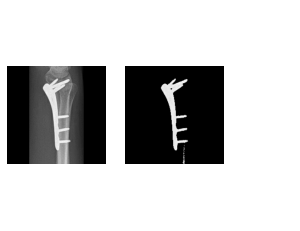

new filepath images_processed/cropped/synthes va ex5 at 10.57.20 AM.png


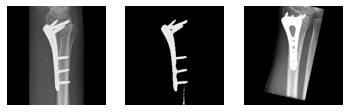

new filepath images_processed/cropped/Acumed ex2 at 9.50.54 AM.png


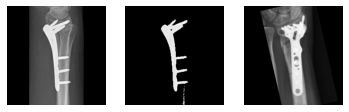

new filepath images_processed/cropped/synthes va ex3 at 4.31.49 AM.png


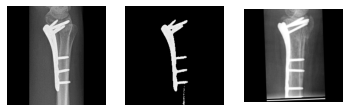

new filepath images_processed/cropped/acumed ex5 at 10.25.26 AM.png


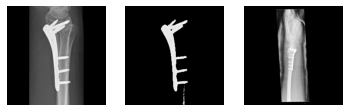

new filepath images_processed/cropped/acumed ex5 at 10.25.57 AM.png


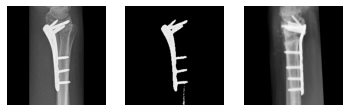

new filepath images_processed/cropped/synthes va ex5 at 2.29.37 PM.png


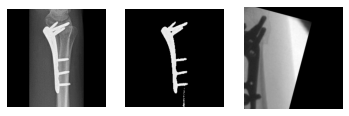

new filepath images_processed/cropped/acumed ex5 at 10.25.02 AM.png


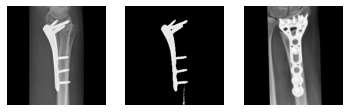

new filepath images_processed/cropped/Acumed ex2 at 9.50.35 AM.png


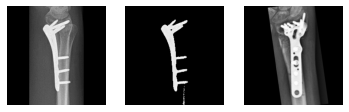

new filepath images_processed/cropped/Acumed ex2 at 9.50.48 AM.png


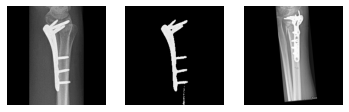

new filepath images_processed/cropped/acumed ex1 at 9.47.24 AM.png


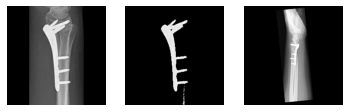

new filepath images_processed/cropped/synthes va ex5 at 2.29.29 PM.png


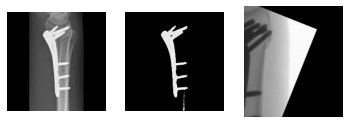

new filepath images_processed/cropped/synthes va ex3 at 4.31.59 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



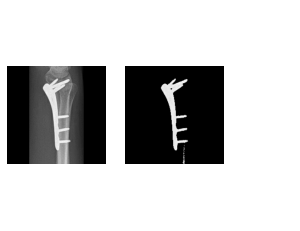

new filepath images_processed/cropped/synthes va ex2 at 4.18.23 AM.png


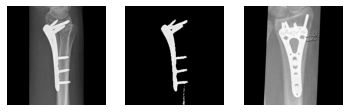

new filepath images_processed/cropped/acumed ex3 at 9.58.16 AM.png


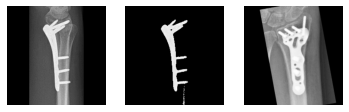

new filepath images_processed/cropped/acumed ex3 at 9.57.42 AM.png


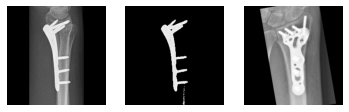

new filepath images_processed/cropped/synthes va ex5 at 10.56.24 AM.png


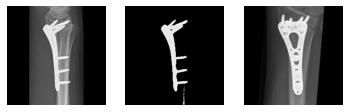

new filepath images_processed/cropped/acumed ex3 at 9.58.32 AM.png


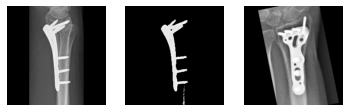

new filepath images_processed/cropped/trimed va ex1 at 4.07.05 AM.png


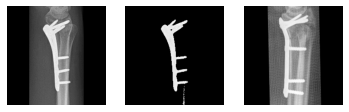

new filepath images_processed/cropped/synthes va ex3 at 4.35.19 AM.png


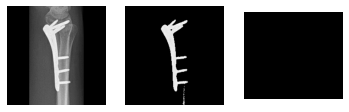

new filepath images_processed/cropped/synthes va ex5 at 2.29.33 PM.png


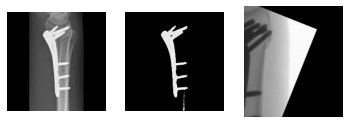

new filepath images_processed/cropped/acumed ex5 at 10.25.06 AM.png


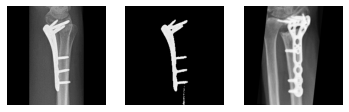

new filepath images_processed/cropped/synthes va ex5 at 2.29.50 PM.png


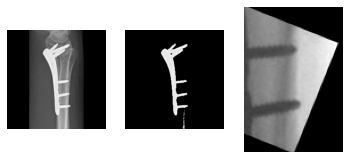

new filepath images_processed/cropped/acumed ex5 at 10.25.22 AM.png


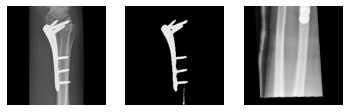

new filepath images_processed/cropped/acumed ex5 at 10.13.29 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



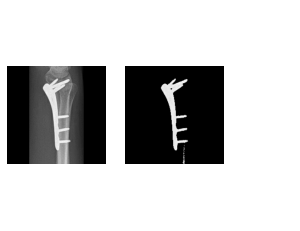

new filepath images_processed/cropped/synthes va ex1-8.png


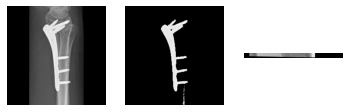

new filepath images_processed/cropped/acumed ex3 at 9.58.28 AM.png


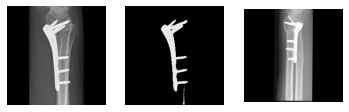

new filepath images_processed/cropped/synthes va ex5 at 10.56.32 AM.png


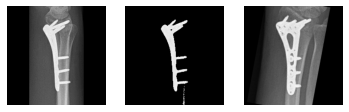

new filepath images_processed/cropped/synthes va ex1-9.png


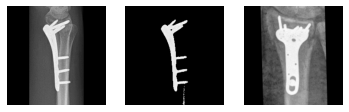

new filepath images_processed/cropped/synthes va ex2 at 4.18.48 AM.png


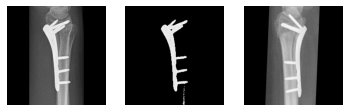

new filepath images_processed/cropped/acumed ex5 at 10.24.34 AM.png


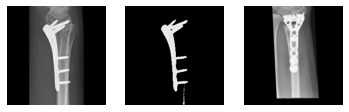

new filepath images_processed/cropped/acumed ex5 at 10.24.38 AM.png


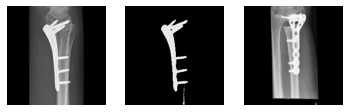

new filepath images_processed/cropped/acumed ex5 at 10.24.45 AM.png


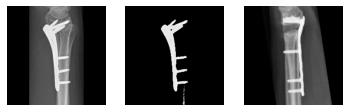

new filepath images_processed/cropped/synthes va ex3 at 4.31.53 AM.png


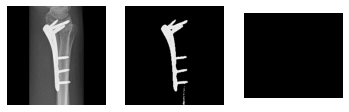

new filepath images_processed/cropped/synthes va ex3 at 4.31.30 AM.png


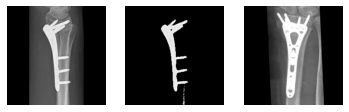

new filepath images_processed/cropped/Acumed ex2 at 9.50.42 AM.png


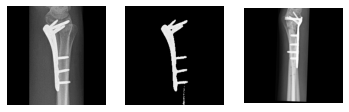

new filepath images_processed/cropped/acumed ex5 at 10.25.16 AM.png


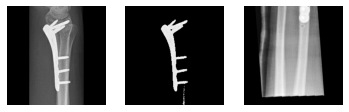

new filepath images_processed/cropped/acumed ex1 at 2.22.39 PM.png


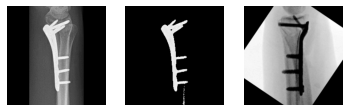

new filepath images_processed/cropped/acumed ex5 at 10.25.20 AM.png


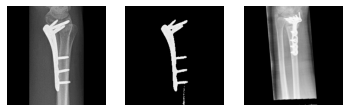

new filepath images_processed/cropped/acumed ex5 at 10.25.32 AM.png


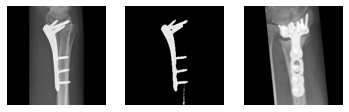

new filepath images_processed/cropped/Acumed ex2 at 9.50.59 AM.png


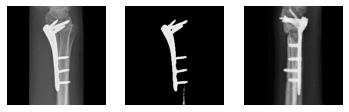

new filepath images_processed/cropped/synthes va ex5 at 2.29.26 PM.png


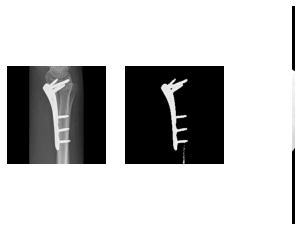

new filepath images_processed/cropped/synthes va ex5 at 2.29.45 PM.png


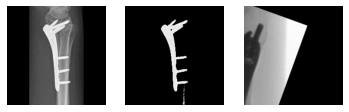

new filepath images_processed/cropped/synthes va ex3 at 4.31.35 AM.png


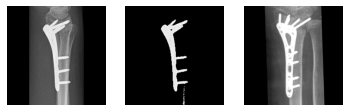

new filepath images_processed/cropped/trimed va ex1 at 4.06.59 AM.png


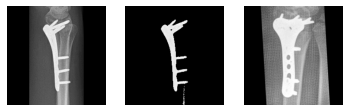

new filepath images_processed/cropped/synthes va ex5 at 2.29.57 PM.png


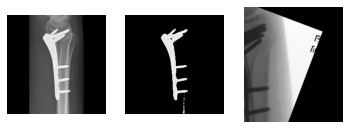

new filepath images_processed/cropped/acumed ex5 at 10.25.37 AM.png


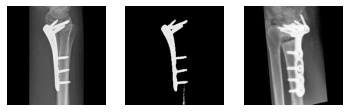

new filepath images_processed/cropped/acumed ex5 at 10.13.53 AM.png


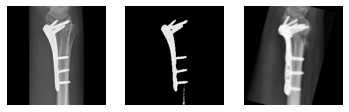

new filepath images_processed/cropped/synthes va ex5 at 2.29.10 PM.png


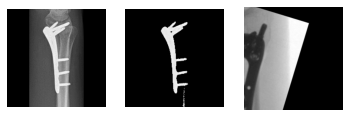

new filepath images_processed/cropped/synthes va ex2 at 4.18.04 AM.png


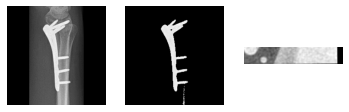

new filepath images_processed/cropped/synthes va ex5 at 10.56.35 AM.png


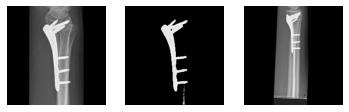

new filepath images_processed/cropped/synthes va ex2 at 4.18.08 AM.png


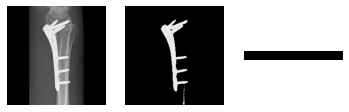

new filepath images_processed/cropped/Acumed ex2 at 9.51.06 AM.png


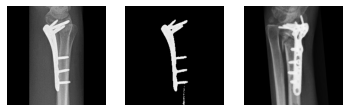

new filepath images_processed/cropped/acumed ex3 at 9.58.23 AM.png


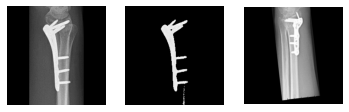

new filepath images_processed/cropped/synthes va ex5 at 10.56.54 AM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



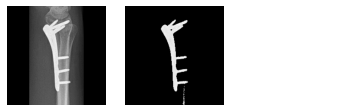

new filepath images_processed/cropped/synthes va ex1-7.png


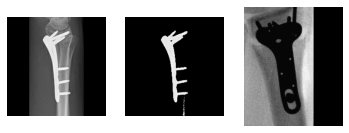

new filepath images_processed/cropped/trimed va ex1 at 4.06.49 AM.png


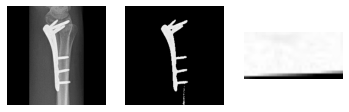

new filepath images_processed/cropped/synthes va ex5 at 2.22.45 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



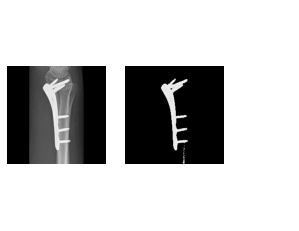

new filepath images_processed/cropped/acumed ex5 at 10.13.43 AM.png


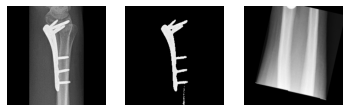

new filepath images_processed/cropped/acumed ex5 at 10.25.48 AM.png


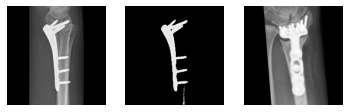

new filepath images_processed/cropped/synthes va ex1-6.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



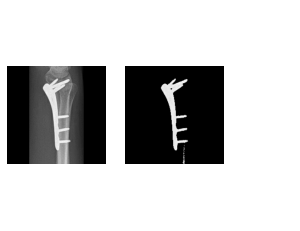

new filepath images_processed/cropped/acumed ex3 at 9.58.37 AM.png


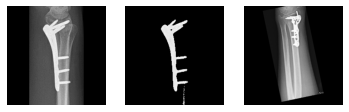

new filepath images_processed/cropped/synthes va ex1-14.png


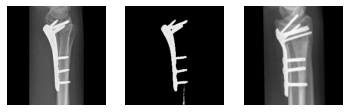

new filepath images_processed/cropped/synthes va ex5 at 10.56.50 AM.png


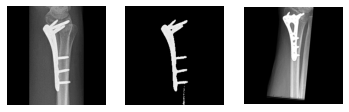

new filepath images_processed/cropped/acumed ex5 at 10.25.52 AM.png


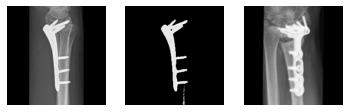

new filepath images_processed/cropped/acumed ex1 at 2.22.36 PM.png


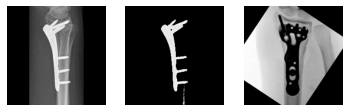

new filepath images_processed/cropped/synthes va ex3 at 4.35.14 AM.png


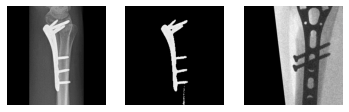

new filepath images_processed/cropped/synthes va ex5 at 2.29.20 PM.png


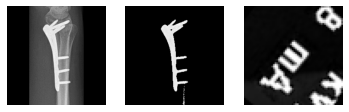

new filepath images_processed/cropped/acumed ex3 at 2.19.58 PM.png


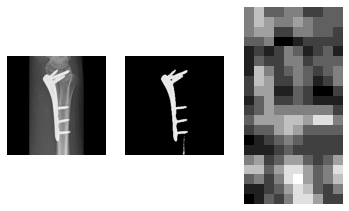

new filepath images_processed/cropped/synthes va ex3 at 4.31.15 AM.png


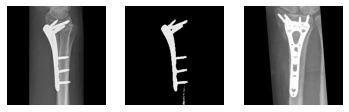

new filepath images_processed/cropped/acumed ex1 at 9.47.19 AM.png


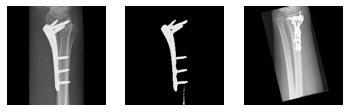

new filepath images_processed/cropped/acumed ex3 at 2.20.05 PM.png
OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



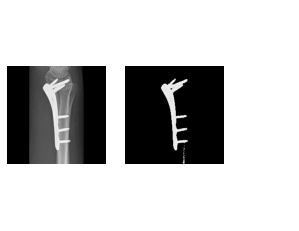

new filepath images_processed/cropped/acumed ex5 at 10.13.34 AM.png


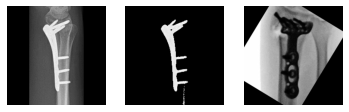

new filepath images_processed/cropped/acumed ex5 at 10.13.49 AM.png


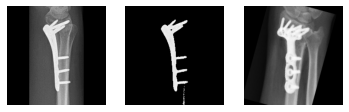

new filepath images_processed/cropped/acumed ex5 at 10.25.42 AM.png


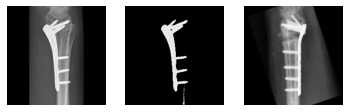

new filepath images_processed/cropped/acumed ex5 at 10.13.38 AM.png


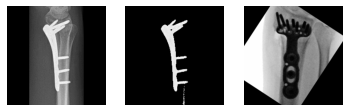

new filepath images_processed/cropped/acumed ex1 at 9.47.15 AM.png


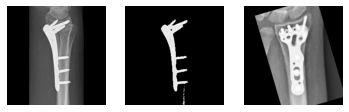

new filepath images_processed/cropped/synthes va ex1-13.png


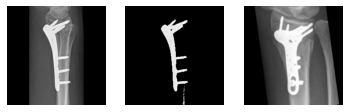

new filepath images_processed/cropped/synthes va ex3 at 4.31.19 AM.png


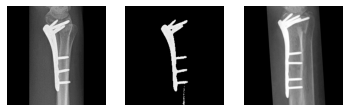

new filepath images_processed/cropped/synthes va ex1-12.png


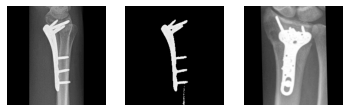

new filepath images_processed/cropped/synthes va ex5 at 2.29.53 PM.png


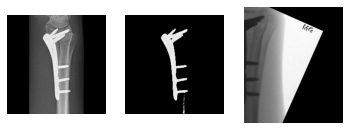

new filepath images_processed/cropped/synthes va ex3 at 4.31.23 AM.png


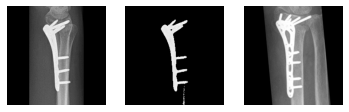

new filepath images_processed/cropped/acumed ex5 at 10.25.09 AM.png


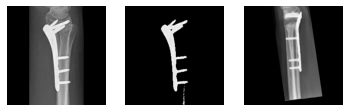

new filepath images_processed/cropped/synthes va ex3 at 4.31.40 AM.png


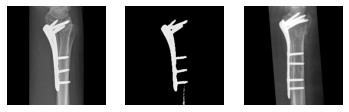

new filepath images_processed/cropped/synthes va ex2 at 4.18.36 AM.png


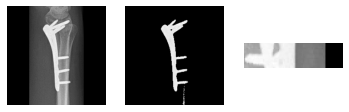

new filepath images_processed/cropped/synthes va ex1-10.png


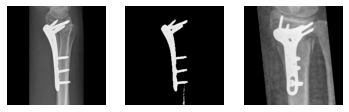

new filepath images_processed/cropped/synthes va ex1-11.png


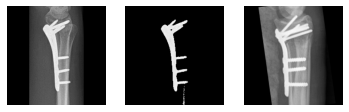

new filepath images_processed/cropped/synthes va ex5 at 10.56.40 AM.png


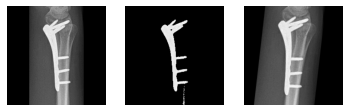

In [6]:
for filepath, (original, edited, morph) in rotated.items():

    contours, hierarchy = cv2.findContours(morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) if cv2.boundingRect(c)[2] < (edited.shape[1]) * 0.8 else -1 for c in contours]
    max_index = np.argmax(areas)
    cnt = contours[max_index]

    colored_image = cv2.cvtColor(edited, cv2.COLOR_GRAY2BGR)
    x, y, w, h = cv2.boundingRect(cnt)
    halfW, halfH = (w // 2, h // 2)
    
    cx, cy = (x + halfW, y + halfH)
    
    majorHalf = halfW if w > h else halfH
    
    majorHalf += 20 #padding
    
    crop_img = original[cy-majorHalf:cy+majorHalf, cx-majorHalf:cx+majorHalf]

    
    
    filepath = filepath.replace('images', 'images_processed')

    try:
        os.makedirs('/'.join(filepath.split('/')[:-1]))
    except Exception as e:
        pass
    print('new filepath', filepath)
    try:
        cv2.imwrite(filepath, crop_img)
    except Exception as e:
        print(e)
        



    f, axarr = plt.subplots(1,3)
    axarr[0].axis('off')
    axarr[0].imshow(image, cmap='gray')
    axarr[1].axis('off')
    axarr[1].imshow(thresh, cmap='gray')
    axarr[2].axis('off')
    axarr[2].imshow(crop_img, cmap='gray')
    plt.show(block=True)